In [ ]:
!pip install mediapipe-model-maker

In [ ]:
import boto3
import numpy as np
import pandas as pd
from mediapipe_model_maker.python.vision import gesture_recognizer
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
pip install scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn() 

In [ ]:
!aws s3 cp s3://arslprocessed/output-images/ . --recursive

In [30]:
Data_Path = "output-images"

In [ ]:
data = gesture_recognizer.Dataset.from_folder(
    dirname=Data_Path,
    hparams=gesture_recognizer.HandDataPreprocessingParams()
)

train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

In [ ]:
train_data.gen_tf_dataset()

In [6]:
import shutil
import os

dir_path = 'output-images/.ipynb_checkpoints'

if os.path.exists(dir_path) and os.path.isdir(dir_path):
    shutil.rmtree(dir_path)
    print("Directory and all its contents have been removed.")
else:
    print("Directory does not exist.")


Directory and all its contents have been removed.


In [ ]:
hparams = gesture_recognizer.HParams(batch_size = 2,
                                     learning_rate = 0.001,
                                     gamma = 3,
                                     epochs = 30,
                                     export_dir="exported_model")

options = gesture_recognizer.GestureRecognizerOptions(hparams=hparams)
model = gesture_recognizer.GestureRecognizer.create(
    train_data=train_data,
    validation_data=validation_data,
    options=options
)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hand_embedding (InputLayer  [(None, 128)]             0         
 )                                                               
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 re_lu_3 (ReLU)              (None, 128)               0         
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 custom_gesture_recognizer_  (None, 30)                3870      
 out (Dense)                                                     
                                                           

INFO:tensorflow:Training the models...


Epoch 1/30
8867/8867 [==============================] - 12s 1ms/step - loss: 1.5325 - categorical_accuracy: 0.4820 - val_loss: 0.5047 - val_categorical_accuracy: 0.7817 - lr: 0.0010
Epoch 2/30
7770/8867 [=========================>....] - ETA: 1s - loss: 1.1916 - categorical_accuracy: 0.5793

In [34]:
loss, acc = model.evaluate(test_data, batch_size=1)
print(f"Test loss:{loss}, Test accuracy:{acc}")

2217/2217 [==============================] - 3s 732us/step - loss: 0.7408 - categorical_accuracy: 0.7808
Test loss:0.7408298254013062, Test accuracy:0.7807848453521729


In [35]:
model.export_model()


Using existing files at /tmp/model_maker/gesture_recognizer/gesture_embedder.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/palm_detection_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/hand_landmark_full.tflite
Using existing files at /tmp/model_maker/gesture_recognizer/canned_gesture_classifier.tflite
INFO:tensorflow:Assets written to: /tmp/tmpllajwuuw/saved_model/assets


INFO:tensorflow:Assets written to: /tmp/tmpllajwuuw/saved_model/assets
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 4, Total Ops 11, % non-converted = 36.36 %
 * 4 ARITH ops

- arith.constant:    4 occurrences  (f32: 4)



  (f32: 1)
  (f32: 1)
  (f32: 1)
  (f32: 1)


1/1 [==============================] - 0s 40ms/step


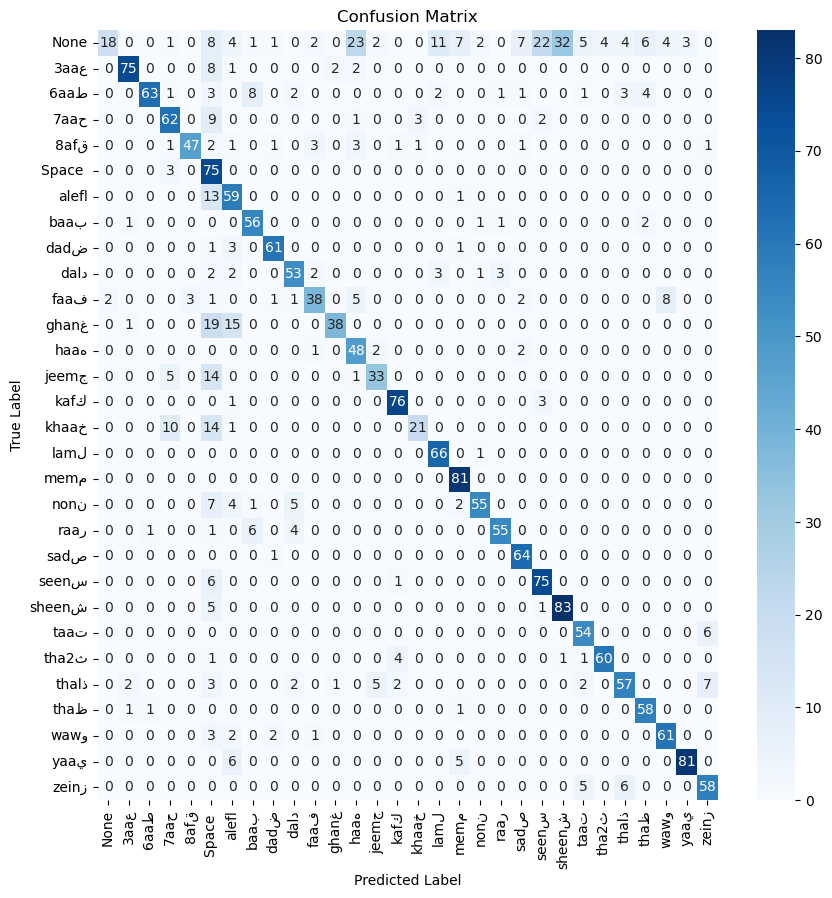

In [36]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    return plt.show()

batch_size = 32 
tf_test_data = test_data.gen_tf_dataset(batch_size=batch_size, is_training=False, shuffle=False)

y_pred = []
y_true = []

for batch in tf_test_data:
    images, labels = batch
    predictions = model._model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


classes = test_data.label_names  
plot_confusion_matrix(y_true, y_pred, classes)

In [40]:
def plot_confusion_matrix(y_true, y_pred, classes, file_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(file_path)
    plt.close()
    
output_file_path = 'confusion_matrix.png'

plot_confusion_matrix(y_true, y_pred, classes, output_file_path)


In [41]:
metric_functions = model._metric_functions + [tf.keras.metrics.F1Score(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
model._model.compile(
    optimizer=model._optimizer,
    loss=model._loss_function,
    metrics=metric_functions,
)

metrics = model.evaluate(test_data)
print(metrics)

70/70 [==============================] - 2s 2ms/step - loss: 0.5975 - categorical_accuracy: 0.7930 - f1_score: 0.7962 - precision: 0.8309 - recall: 0.7713
[0.5975237488746643, 0.792963445186615, array([0.24870467, 0.8994082 , 0.82580644, 0.77777773, 0.8235294 ,
       0.63829786, 0.7070707 , 0.85294116, 0.9104478 , 0.7883212 ,
       0.7407407 , 0.61818177, 0.7596899 , 0.6947369 , 0.9202454 ,
       0.63888884, 0.9041096 , 0.9050279 , 0.82608694, 0.85937494,
       0.9078014 , 0.81249994, 0.82587063, 0.8346456 , 0.9160306 ,
       0.74999994, 0.90625   , 0.88405806, 0.9257143 , 0.7851852 ],
      dtype=float32), 0.8309037685394287, 0.7713125944137573]
